## Description
This notebooks demonstrates Lloyd's k-means clustering algorithm with image compression.

In [2]:
from PIL import Image
import numpy as np
import sklearn
from pathlib import Path
import matplotlib.pyplot as plt

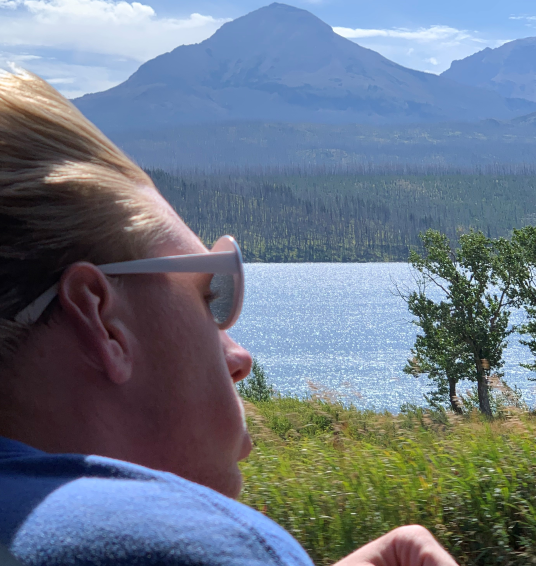

In [3]:
path = Path()
orig_img = Image.open(path / 'Resources/kmeans_image.png')
display(orig_img)

This is the original image. We are going to attempt to use k-means clustering with Lloyd's algorithm (the basic algorithm) to segment its color channels.

In [4]:
# send it to numpy
img = np.array(orig_img)
img.shape

(566, 536, 3)

The basic algorithm:
1. Choose $k$, the number of clusters
2. Randomly assign a cluster to each observation
3. Calculate the ***Centroid*** of each cluster (this is the mean of the cluster)
4. For each observation, identify the closes centroid and reassign it to that cluster
5. Repeat (3) and (4) until the cluster assignments have stopped changing

Once cluster assignments have stopped changing, we will have minimized the ***Within Cluster Variation*** across all $k$ clusters (i.e. the variances of the clusters).

In [5]:
tot_mean = img.sum(axis = 1).sum(axis=0)  / (img.shape[0] * img.shape[1])
TSS = ((img - tot_mean)**2).sum()
print(f'{TSS:,.2f}')

3,549,156,505.68


In [25]:
np.random.seed(42)
k = 5

# random initial cluster assignment
clusters = np.random.randint(0, k, size=(img.shape[0], img.shape[1]))
clusters.shape

(566, 536)

### Centroid and within Cluster Variation
The centroid of a cluster is simply the mean of the observations within that cluster. For the $u^{th}$ cluster, the mean of variable $x_j$ is:
$$
\bar{x}_{u,j} = \frac{1}{|C_u|} \sum_{i\in C_u} x_{i, j}
$$
- Where $C_u$ is the $u^{th}$ cluster and $|C_u|$ is the number of observations in $C_u$

Then, the within cluster variation for the $u^{th}$ cluster is the variance *summed across all $p$ variables* in the cluster:
$$
W(C_u) = 2\sum_{i \in C_u} \sum_{j=1}^p (x_{i,j} - \bar{x}_{u, j})^2
$$

Finally, the ***Total Within Cluster Variation*** is the sum of the within cluster variation across all $k$ clusters:
$$
\sum_{u=1}^k = W(C_u)
$$

In [26]:
# Euclidean distance:
def dist(x1, x2):
    return ((x1 - x2) ** 2) ** 0.5

# get values by cluster
def cluster_vals(label, clusters, img):
    w, h, d = img.shape
    x = (clusters.copy() == label).astype(int)         # set elements of c cluster to 1, others to 0
    Cu = x.sum()
    x = np.repeat(x.reshape(w, h, 1), d, axis=2)    # duplicate x for three RGB channels
    return img * x, Cu

# compute centroids
def comp_centroids(k, img, clusters, centroids=None):
    w, h, d = img.shape
    wcVars = []
    if type(centroids) == type(None): centroids = [0] * k
    for c in range(0, k):
        cluster, Cu = cluster_vals(c, clusters, img)
        
        i, j, k = np.nonzero(cluster)
        cluster_non_zero = cluster[i, j]    # nonzero entries of cluster c

        # only update centroid if it is nearest to points - empty clusters do not update centroids
        if Cu != 0:
            centroids[c] = cluster.sum(axis=1).sum(axis=0) / Cu
        
        var = dist(cluster_non_zero, centroids[c])**2

        wcVars.append(var.sum())    # within-cluster variation

    return np.array(centroids), np.array(wcVars)

centroids, wcVars = comp_centroids(k, img, clusters)
centroids, wcVars

(array([[107.47941817, 119.14588693, 133.41467115],
        [107.33871233, 118.97847856, 133.39081686],
        [107.64039025, 119.36797469, 133.38662603],
        [107.41610118, 119.05669754, 133.40921624],
        [107.49737214, 119.1716815 , 133.50867194]]),
 array([2.13069568e+09, 2.14174225e+09, 2.11062228e+09, 2.12490074e+09,
        2.13937797e+09]))

Note that I sum over the first two axes successively in order to obtain the averages for each RGB variable. The default numpy `.sum()` method sums over all three axes successively.

Note also that I only update the centroid values for clusters that *have* observations assigned to them. Initially, this will be all clusters. However, after future iterations, some centroids may not be nearest to any observations - effectively emptying, or "orphaning" the cluster. Instead of removing these clusters, I leave them but allow their centroids to remain unchanged.

Now, on to computing the distances:

$$
\text{Euclidean Distance}: \ \ \sqrt{\sum_{j=1}^p (x_{i, j} - x_{m, j})^2}
$$

In [19]:
# compute distances and reassign clusters
def update_clusters(img, clusters, centroids):
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            min_dist = np.argmin(np.sqrt(((centroids - img[i, j])**2).sum(axis=1)))
            if not isinstance(min_dist, np.int64): print(type(min_dist))
            clusters[i, j] = min_dist
        
    return clusters

clusters = update_clusters(img, clusters, np.array(centroids))
clusters, clusters.shape

(array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 (566, 536))

This is a very slow implementation, but this demo is meant to be illustrative and I'm not a great programmer. There are ample optimized k-means implementations in common packages like sklearn.

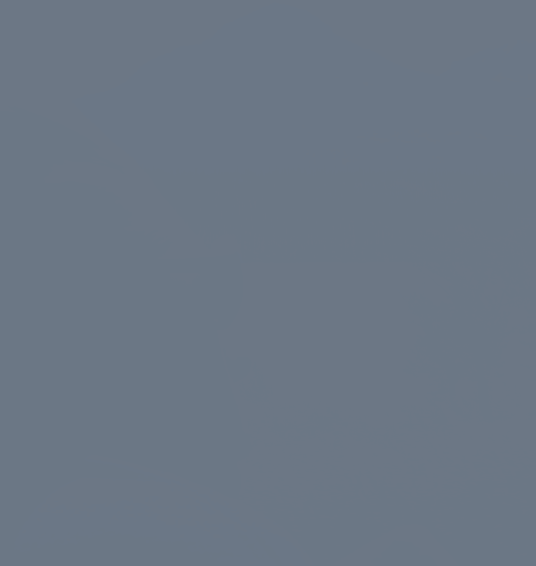

In [21]:
def output_image(centroids, clusters):
    # round off the centroid values to convert to RGB
    centroids = np.around(centroids, decimals=0)

    # expand for 3 RGB channels
    new_img = np.repeat(clusters.reshape(clusters.shape[0], clusters.shape[1], 1), 3, axis=2).copy()

    # populate new_img with "predicted" RGB values - i.e. cluster centroids
    for i in range(clusters.shape[0]):
        for j in range(clusters.shape[1]):
            new_img[i][j] = centroids[clusters[i][j]]

    # convert to image
    new_img = Image.fromarray(np.uint8(new_img)).convert('RGB')
    display(new_img)

output_image(centroids, clusters)

Now, we repeat this process until no new assignments are made; that is, until the centroids are unchanged.

Step: 1,  Within-Cluster Variation: 10,647,038,462.34


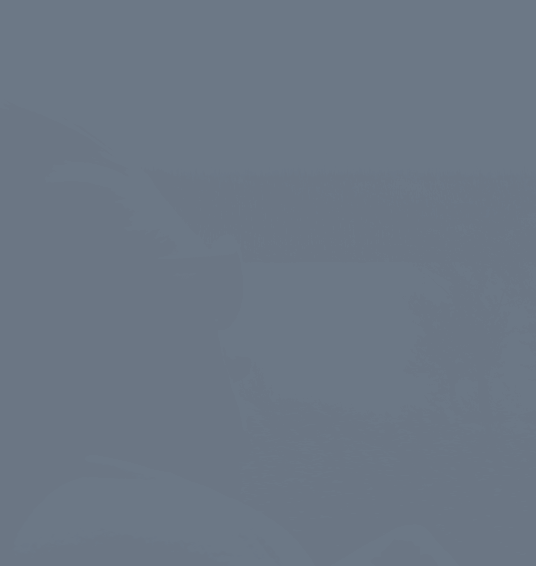

Step: 2,  Within-Cluster Variation: 3,243,291,858.26


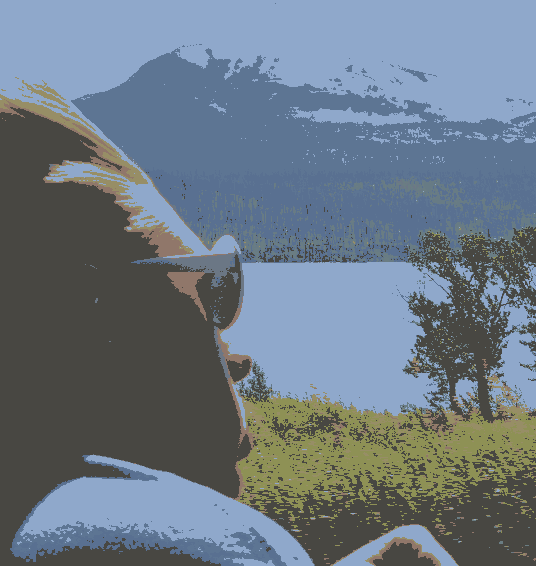

Step: 3,  Within-Cluster Variation: 1,513,348,138.40


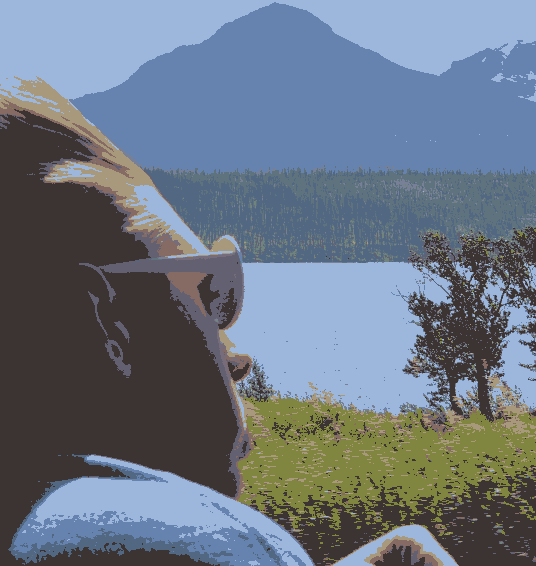

Step: 4,  Within-Cluster Variation: 897,604,739.81


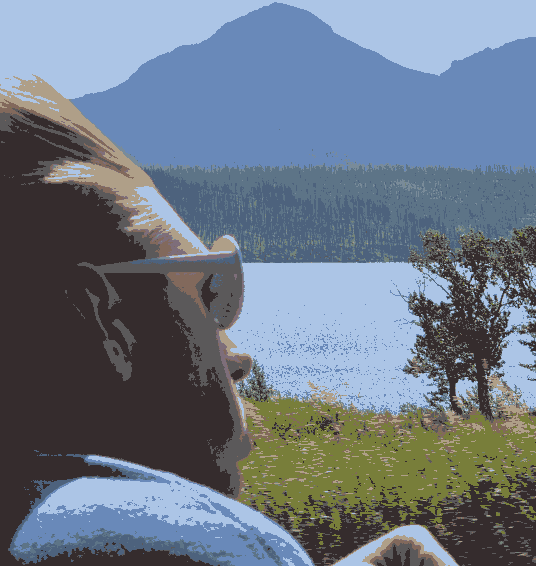

Step: 5,  Within-Cluster Variation: 785,189,657.75


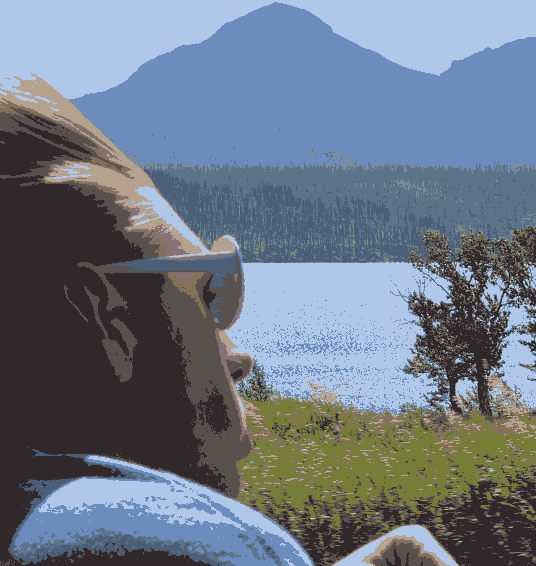

Step: 6,  Within-Cluster Variation: 730,656,303.45


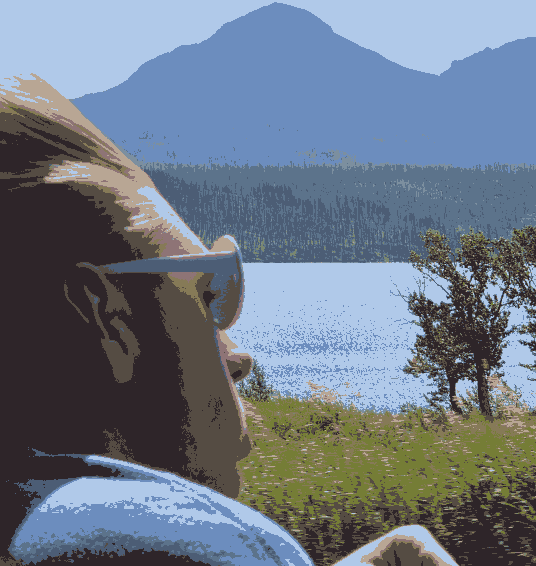

Step: 7,  Within-Cluster Variation: 701,012,369.18


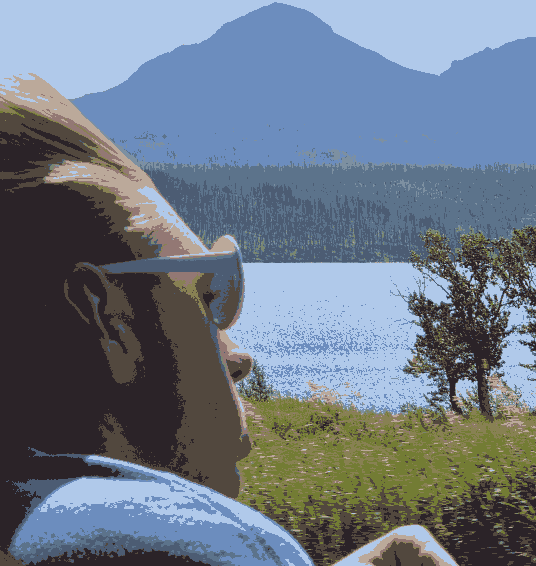

Step: 8,  Within-Cluster Variation: 683,248,280.00


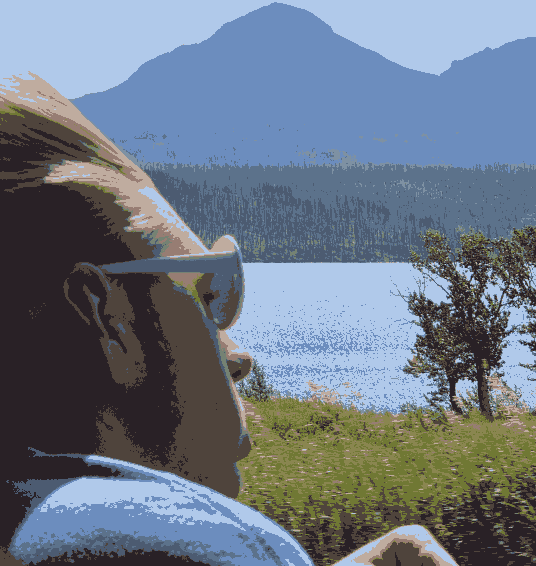

Step: 9,  Within-Cluster Variation: 666,577,908.11


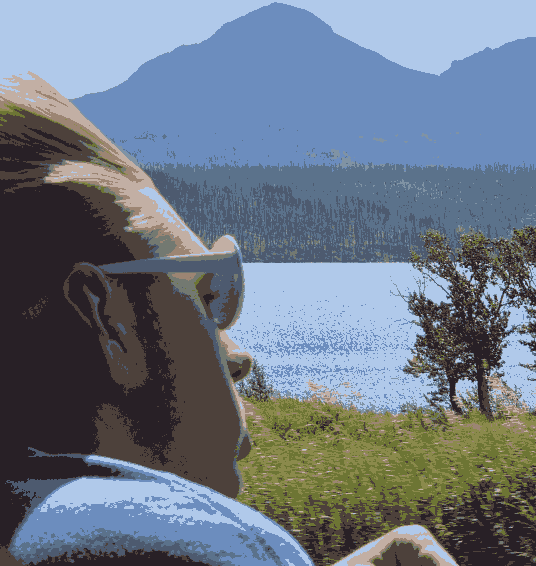

Step: 10,  Within-Cluster Variation: 650,302,073.01


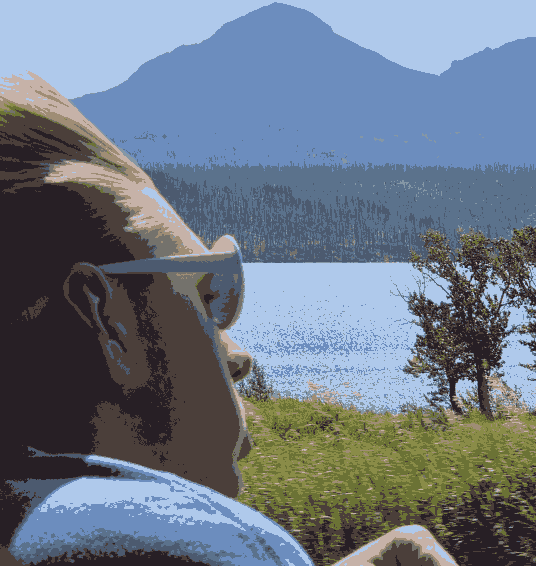

Step: 11,  Within-Cluster Variation: 634,691,627.08


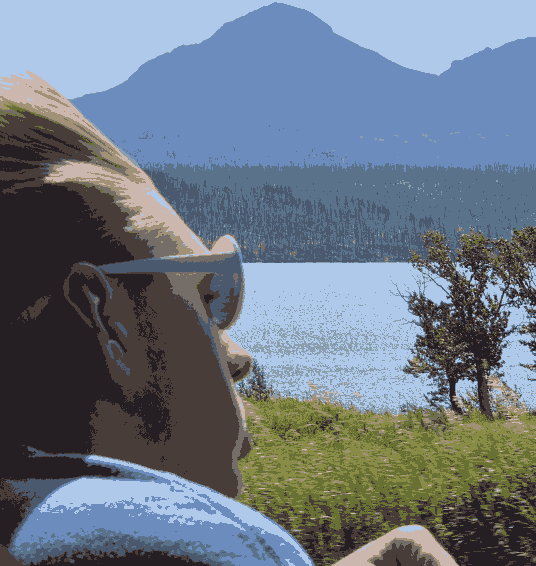

Maximum Step Count Reached: 11


In [32]:
def kMeans(k, data=img, max_steps=100, print_int=10):
    steps = 0
    wcVars = []
    centroids, old_centroids = np.zeros([k, 3]), np.zeros([k, 3])

    while True: 
        # initial random assignments
        if steps == 0: 
            clusters = np.random.randint(0, k, size=(img.shape[0], img.shape[1]))    
        
        # compute centroids
        centroids, wv = comp_centroids(k, data, clusters, centroids)

        # update clusters
        clusters = update_clusters(img, clusters, centroids)
        wcVars.append(wv)

        diff = (centroids - old_centroids).sum()

        if steps % print_int == 0:
            print(f"Step: {steps + 1},  Within-Cluster Variation: {wcVars[-1].sum():,.2f}")
            output_image(centroids, clusters)

        # threshold for convergence set to near 0
        if abs(diff) <= 0.1:
            print(f'Centroids Converged in {steps} Steps. Total Centroid Change = {(centroids - old_centroids).sum()}')
            break
        elif steps == max_steps:
            print(f'Maximum Step Count Reached: {steps + 1}')
            break
        else:
            old_centroids = centroids.copy()
            steps += 1

    return clusters, centroids, wcVars

clusters, centroids, wcVars = kMeans(k=12, data=img, max_steps=10, print_int=1)

TSS: 3,549,156,505.68, Total Within-Cluster Variation: 634,691,627.08, Diff: 2,914,464,878.60


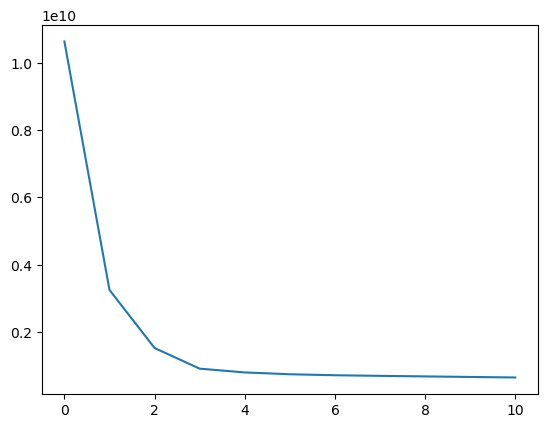

In [33]:
tot_wcVars = np.array(wcVars).sum(axis=1)    # total within-cluster variation
plt.plot(tot_wcVars);
print(f'TSS: {TSS:,.2f}, Total Within-Cluster Variation: {tot_wcVars[-1]:,.2f}, Diff: {TSS - tot_wcVars[-1]:,.2f}')

Time: 0.021s
Total Within-Cluster Variation: 29,871,998.31


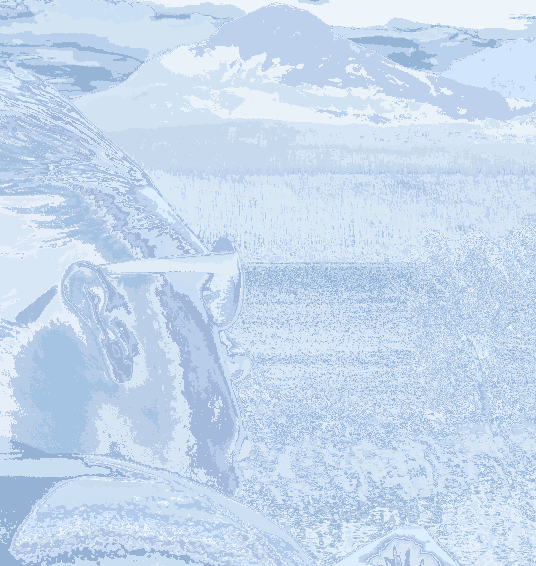

In [342]:
from time import time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 64, random_state = 42, n_init = 'auto', max_iter=300)

w, h, d = tuple(img.shape)
skl_img = img.reshape(w * h, d)    # KMeans expects 2D array

kmeans.fit(skl_img)
t = time()
skl_clusters = kmeans.predict(skl_img)
print(f'Time: {time() - t:0.3f}s')
print(f'Total Within-Cluster Variation: {sum([((skl_img[i] - kmeans.cluster_centers_[skl_clusters[i]])**2).sum() for i in range(skl_clusters.shape[0])]):,.2f}')

skl_img_out = np.uint8(skl_img[skl_clusters].reshape(w, h, -1))
skl_img_out = Image.fromarray(skl_img_out).convert('RGB')
display(skl_img_out);
